In [2]:
import numpy as np
import scipy as scp
import seaborn as sbn
import matplotlib.pyplot as plt
import pickle
import statsmodels as sm

In [3]:
from reliability.Fitters import Fit_Everything

ModuleNotFoundError: No module named 'reliability'

In [4]:
# !pip install github

# Problem specification

$$\mathbb{H} \in \mathbb{R}^{N \times N} $$

$$\mathbb{H}_{ij} \sim \mathcal{N}\left( 0,1 \right) $$
$$\mathbb{H}_{ii} \sim \mathcal{N}\left( 0,2 \right) $$

$$\mathbb{H}^{\mbox{(sym)}} = \frac{\mathbb{H} + \mathbb{H}^{\mbox{T}}}{\sqrt{2}} $$ => GOE

## Defining necesary functions (and testing them)

In [5]:
def generate_H(N: int = 8, seed: int = 13):
    """ return square mtx of given shape (N) """
    #np.random.seed(seed=seed)
    H = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i!=j:
                mu = 0
                sigma = 1
                H[i,j] = mu + sigma * np.random.randn()
            else:
                mu = 0
                sigma = 2
                H[i,i] = mu + sigma * np.random.randn()
    return H

In [6]:
H = generate_H(3)
print(H)

[[-3.38012457 -1.86157283  0.90459721]
 [-0.95289802  0.18062573  0.33441926]
 [-0.73487547 -0.94527796 -1.98810435]]


In [7]:
def symmetrize(H):
    """ symetrizes given matrix """
    return (H+H.T) *(1/np.sqrt(2))

In [8]:
H_sym = symmetrize(H)
print(H_sym)

[[-4.780218   -1.99013142  0.1200114 ]
 [-1.99013142  0.25544335 -0.43194233]
 [ 0.1200114  -0.43194233 -2.81160414]]


In [9]:
def get_eigs(H):
    """returns (ordered) list of eigenvalues of given mtx """
    spectral_analysis = np.linalg.eig(H)
    eig_vals = spectral_analysis[0]
    return eig_vals

In [10]:
get_eigs(H_sym)

array([ 0.99951292, -5.47207046, -2.86382125])

## experiment

In [11]:
""" define a function 'experiment' that  """
def experiment(name:str = 'none', num_of_dims_of_mtx: int = 3, print_result: bool = False, seed = 13):
    """ single experiment """
    result = []
    K = generate_H(num_of_dims_of_mtx, seed=seed)
    K_sym = symmetrize(K)
    eigs = get_eigs(K_sym)
    result.extend(eigs.tolist())
    if print_result:
        print(result)
    return result

In [12]:
# testing experiment function >>
for _ in range(2):
    experiment(num_of_dims_of_mtx=3, print_result=True)

[4.8653806792823895, 0.44685324086018685, -4.898664564939123]
[3.9833602877962204, -2.2918053703234427, -0.5948953493219677]


show it for:
 - `num_of_experiments = 10000` and `num_of_dims_of_mtx = 8`
 - `num_of_experiments = 1000` and `num_of_dims_of_mtx = 80`

In [32]:
num_of_experiments = 100000
num_of_dims_of_mtx = 80
name_of_exp = f'runw_dims{num_of_dims_of_mtx}__expers{num_of_experiments}'
results = []
for i in range(num_of_experiments):
    K = generate_H(num_of_dims_of_mtx)
    K_sym = symmetrize(K)
    eigs = get_eigs(K_sym)
    #results.append(eigs)
    results.extend(eigs.tolist())

#print(results)

In [48]:
name_of_exp = f'_runw_dims{num_of_dims_of_mtx}__expers{num_of_experiments}'

In [55]:
len(results)

8000000

In [56]:
# save current experiment (manual use)
datasave_name = "rawdata" + name_of_exp + ".pk1"
with open(datasave_name, "wb") as file:
    pickle.dump(results, file)

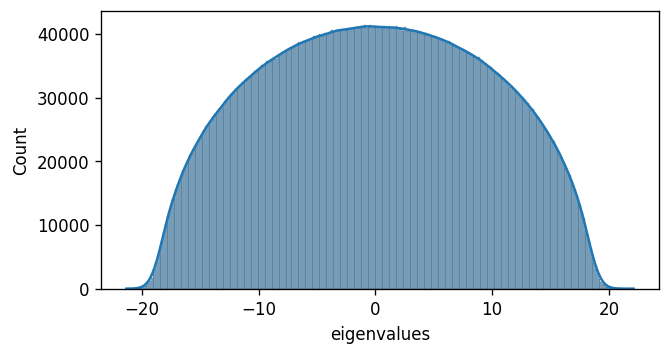

In [57]:
plt.figure(figsize=(6,3), dpi=120)
sbn.histplot(results, kde=True)

plt.xlabel('eigenvalues')
fig_name = "hist" + name_of_exp + ".png"
plt.savefig(fig_name, dpi=300, bbox_inches = "tight")

plt.show()

# analysis of result

In [58]:
# is it normal distribution?
print(f'H_0: eigenvalues have normal distribution')
# Perform the Shapiro-Wilk test
from scipy.stats import shapiro
statistic, p_value = shapiro(results)

if p_value > 0.05:   # Check if the p-value is less than the significance level
    print("Data looks like it comes from a normal distribution (fail to reject H_0, have to accept H_0)")
else:
    print("Data does not look like it comes from a normal distribution (reject H_0), have to accept H_1")

H_0: eigenvalues have normal distribution
Data does not look like it comes from a normal distribution (reject H_0), have to accept H_1


C:\Users\lenov\Documents\GitHub\temp_rndmtx\venv2\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [59]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = results
data = np.array(data)

mean, std = norm.fit(data, method='mle')

Fit results: mean = -0.000307711122628311,  std = 9.327508196778393


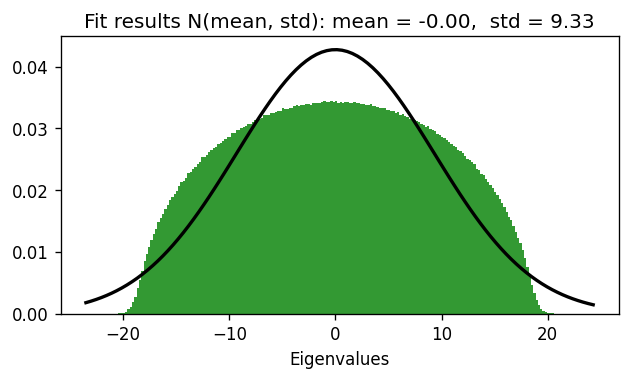

In [60]:
plt.figure(figsize=(6,3), dpi=120)
plt.hist(data, bins=200, density=True, alpha=0.8, color='green')
#sbn.histplot(data, kde=False)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

plt.plot(x, p, 'k', linewidth=2)
print(f'Fit results: mean = {mean},  std = {std}')

plt.title("Fit results N(mean, std): mean = %.2f,  std = %.2f" % (mean, std))
plt.xlabel("Eigenvalues")
#plt.ylabel("Probability Density")

fig_name = "gaussfit" + name_of_exp + ".png"
plt.savefig(fig_name, dpi=300, bbox_inches = "tight")
plt.show()

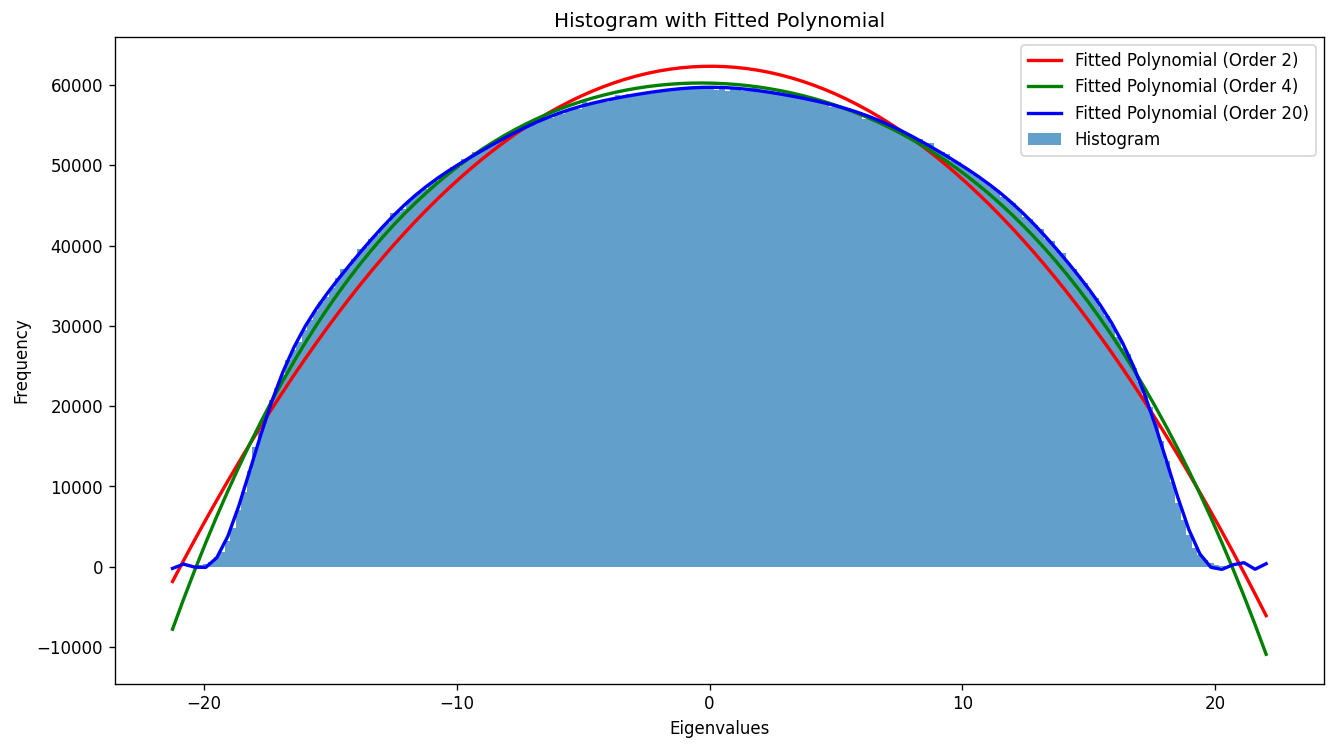

In [61]:
data = results

# Create a histogram
hist, bin_edges = np.histogram(data, bins=200)  # You can adjust the number of bins

# Calculate bin centers for x values
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

# Fit a polynomial of order k to the histogram data
coefficients2 = np.polyfit(bin_centers, hist, 2)
coefficients3 = np.polyfit(bin_centers, hist, 3)
coefficients4 = np.polyfit(bin_centers, hist, 4)
coefficients5 = np.polyfit(bin_centers, hist, 20)

# Create a polynomial function based on the coefficients
fitted_poly2 = np.poly1d(coefficients2)
fitted_poly3 = np.poly1d(coefficients3)
fitted_poly4 = np.poly1d(coefficients4)
fitted_poly5 = np.poly1d(coefficients5)

# Plotting
plt.figure(figsize=(13,7), dpi=120)
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], align='center', alpha=0.7, label='Histogram')
x_range = np.linspace(min(bin_centers), max(bin_centers), 100)  # Generate x values for the fitted polynomial
plt.plot(x_range, fitted_poly2(x_range),'r', label=f'Fitted Polynomial (Order {2})', linewidth=2)
#plt.plot(x_range, fitted_poly3(x_range),'y', label=f'Fitted Polynomial (Order {3})', linewidth=2)
plt.plot(x_range, fitted_poly4(x_range),'g', label=f'Fitted Polynomial (Order {4})', linewidth=2)
plt.plot(x_range, fitted_poly5(x_range),'b', label=f'Fitted Polynomial (Order {20})', linewidth=2)
#plt.plot(x_range, fitted_poly2(x_range),'r*', label=f'Fitted Polynomial (Order {2})')
#plt.plot(x_range, fitted_poly3(x_range),'g*', label=f'Fitted Polynomial (Order {3})')
#plt.plot(x_range, fitted_poly4(x_range),'b*', label=f'Fitted Polynomial (Order {4})')
#plt.plot(x_range, fitted_poly5(x_range),'y*', label=f'Fitted Polynomial (Order {5})')
plt.xlabel('Eigenvalues')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Histogram with Fitted Polynomial')
fig_name = "polyfit" + name_of_exp + ".png"
plt.savefig(fig_name, dpi=300, bbox_inches = "tight")
plt.show()


## END

C:\Users\lenov\AppData\Local\Temp\ipykernel_22104\4176433263.py:7: RuntimeWarning: invalid value encountered in sqrt
  return k + np.sqrt(r**2 - (x - h)**2)
C:\Users\lenov\Documents\GitHub\temp_rndmtx\venv2\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\lenov\AppData\Local\Temp\ipykernel_22104\4176433263.py:11: RuntimeWarning: invalid value encountered in sqrt
  return k + np.sqrt(1 - ((x - h) / a)**2) * b


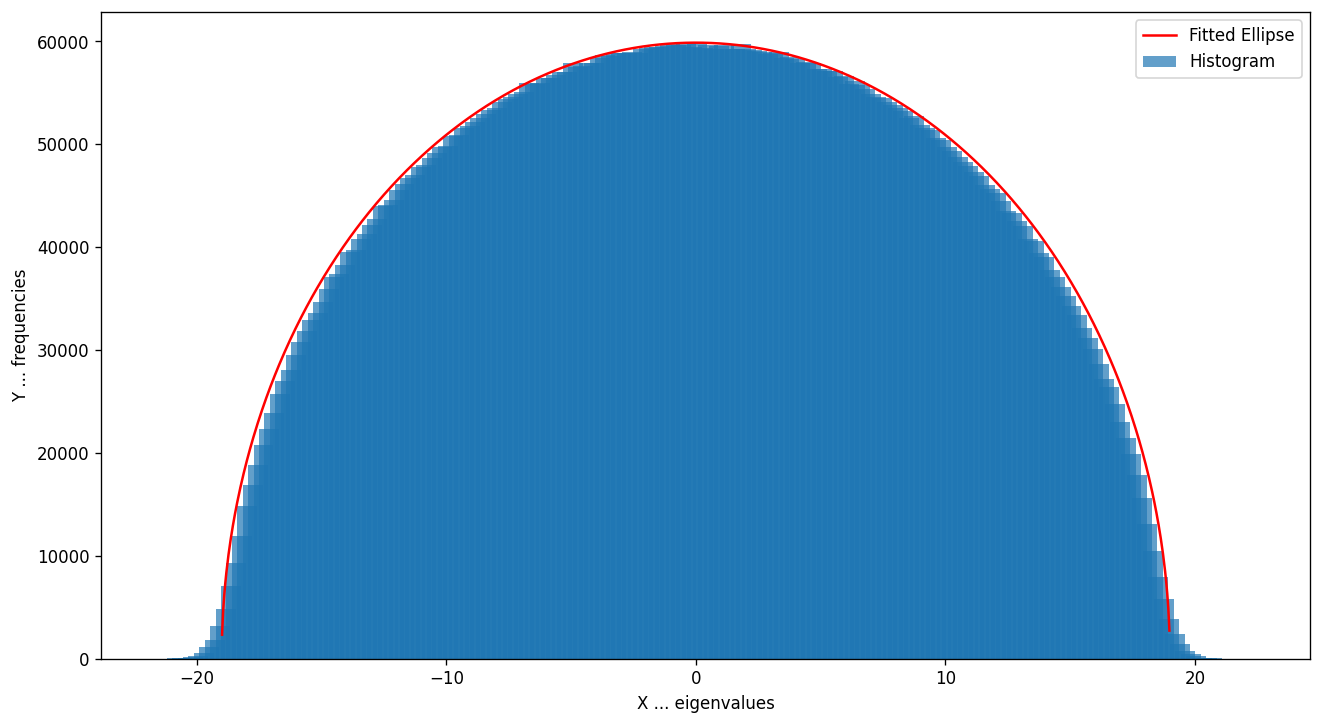

In [62]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function for a semicircle
def semicircle(x, r, h, k):
    return k + np.sqrt(r**2 - (x - h)**2)

# Define the function for an ellipse
def ellipse(x, a, b, h, k):
    return k + np.sqrt(1 - ((x - h) / a)**2) * b

# Load your data (replace with your actual data)
x_data = np.array(bin_centers)
y_data = np.array(hist)

# Initial guesses for the parameters
initial_guess_semicircle = [20, 0, 0]
max_of_hist = np.max(y_data)
initial_guess_ellipse = [19, max_of_hist, 0, 0]

# Fit the data to the semicircle function
params_semicircle, _ = curve_fit(semicircle, x_data, y_data, p0=initial_guess_semicircle)
optimized_radius_semicircle, optimized_x_center_semicircle, optimized_y_center_semicircle = params_semicircle

# Fit the data to the ellipse function
params_ellipse, _ = curve_fit(ellipse, x_data, y_data, p0=initial_guess_ellipse)
optimized_a, optimized_b, optimized_x_center_ellipse, optimized_y_center_ellipse = params_ellipse

# Generate points for the fitted curves
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit_semicircle = semicircle(x_fit, optimized_radius_semicircle, optimized_x_center_semicircle, optimized_y_center_semicircle)
y_fit_ellipse = ellipse(x_fit, optimized_a, optimized_b, optimized_x_center_ellipse, optimized_y_center_ellipse)

# Plot the original data and the fitted curves in a single image
plt.figure(figsize=(13,7), dpi=120)
plt.bar(x_data, y_data, align='center', alpha=0.7, label='Histogram')
#plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], align='center', alpha=0.5, label='Histogram')
#plt.plot(x_fit, y_fit_semicircle, label='Fitted Semicircle', color='red')
plt.plot(x_fit, y_fit_ellipse, label='Fitted Ellipse', color='red')
plt.legend()
plt.xlabel('X ... eigenvalues')
plt.ylabel('Y ... frequencies')
fig_name = "ellipsefit" + name_of_exp + ".png"
plt.savefig(fig_name, dpi=300, bbox_inches = "tight")
plt.show()


nice, but let's estimate those initial parameters :

In [82]:
import numpy as np
from sklearn.decomposition import PCA

def estimate_initial_guess_ellipse_pca(x_data, y_data):
    # Create a data matrix
    data = np.column_stack((x_data, y_data))

    # Perform Principal Component Analysis (PCA)
    pca = PCA(n_components=2)
    pca.fit(data)

    # Extract the major and minor axes lengths and orientation
    major_axis_length = 2 * np.sqrt(pca.explained_variance_[0])
    minor_axis_length = 2 * np.sqrt(pca.explained_variance_[1])
    orientation = np.arctan2(*pca.components_[0])

    # Calculate the center of the ellipse
    center_x, center_y = np.mean(x_data), np.mean(y_data)

    return major_axis_length, minor_axis_length, center_x, center_y, orientation


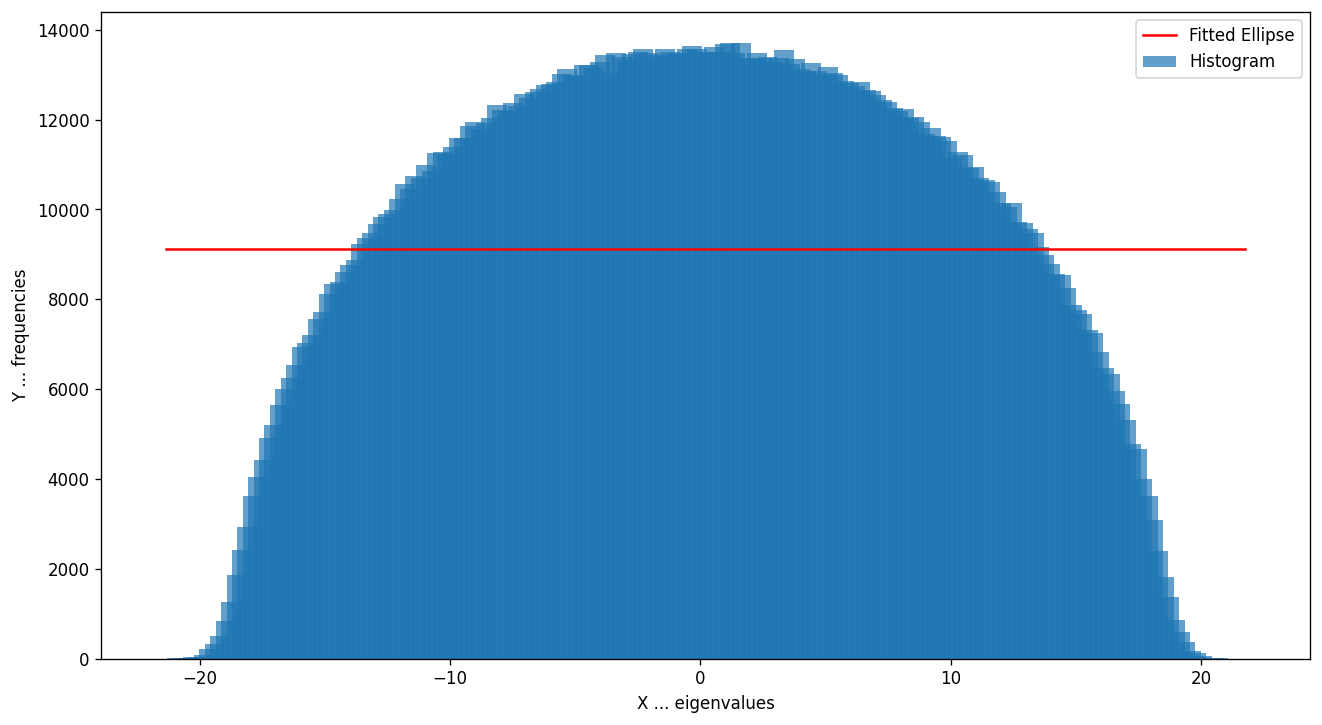

In [83]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function for an ellipse
def ellipse(x, a, b, h, k):
    return k + np.sqrt(1 - ((x - h) / a)**2) * b

# Load your data (replace with your actual data)
x_data = np.array(bin_centers)
y_data = np.array(hist)

# Initial guesses for the parameters
major_axis_length, minor_axis_length, center_x, center_y, orientation = estimate_initial_guess_ellipse_pca(x_data, y_data)

initial_guess_ellipse = [19, 13600, 0, 0]
initial_guess_ellipse = [major_axis_length, minor_axis_length, 0, 0]
# Fit the data to the ellipse function
params_ellipse, _ = curve_fit(ellipse, x_data, y_data, p0=initial_guess_ellipse)
optimized_a, optimized_b, optimized_x_center_ellipse, optimized_y_center_ellipse = params_ellipse

# Generate points for the fitted curves
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit_ellipse = ellipse(x_fit, optimized_a, optimized_b, optimized_x_center_ellipse, optimized_y_center_ellipse)

# Plot the original data and the fitted curves in a single image
plt.figure(figsize=(13,7), dpi=120)
plt.bar(x_data, y_data, align='center', alpha=0.7, label='Histogram')
plt.plot(x_fit, y_fit_ellipse, label='Fitted Ellipse', color='red')
plt.legend()
plt.xlabel('X ... eigenvalues')
plt.ylabel('Y ... frequencies')
plt.savefig('fitting_ellipse.png', dpi=300)
plt.show()


## paralelize

In [16]:
import multiprocessing

In [17]:
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

Number of CPU cores available: 16


In [ ]:
if __name__ == "__main__":
    # Number of parallel processes
    num_processes = 4  # You can adjust this to your hardware capabilities
    num_of_experiments = 10
    num_of_dims_of_mtx = 8

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Define the arguments for each run of function 'experiment()'
    a_values = [None] * num_of_experiments  # names of experiments
    b_values = [num_of_dims_of_mtx] * num_of_experiments  # dimensions of matrices
    c_values = [False] * num_of_experiments  # printing suppresed
    d_values = [13] * num_of_experiments  # Example values for 'c'\
    d_values = list(range(1, num_of_experiments+1)) # random seeds (otherwise each thread gives deterministic results)

    # Create a list of argument tuples for foo
    # args for 'experiment' func >>> (name:str = 'none', num_of_dims_of_mtx: int = 3, print_result: bool = False)
    arguments = [(name, num_of_dims_of_mtx, print_result, seed) for name, num_of_dims_of_mtx, print_result, seed in zip(a_values, b_values, c_values, d_values)]

    # Use Pool.starmap to run foo in parallel
    results = pool.starmap(experiment, arguments)

    # Close the pool (no more tasks can be added)
    pool.close()

    # Wait for all processes to complete
    pool.join()

    # 'results' will contain the results of running foo for each set of arguments
    #print(results)


In [ ]:
len(results)

In [ ]:
# concatenate values from all pools into one list
results_par = [item for sublist in results for item in sublist]

In [ ]:
plt.figure(figsize=(6,3), dpi=120)
sbn.histplot(results_par, kde=True)

plt.xlabel('eigenvalues')
plt.savefig('test_img.png', dpi=300)

plt.show()

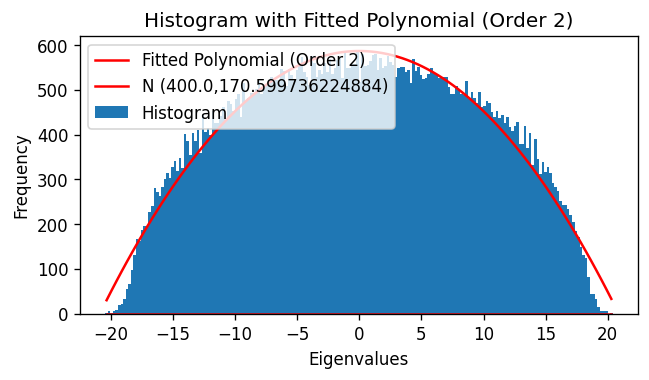

In [108]:
import numpy as np
import matplotlib.pyplot as plt

data = results

hist, bin_edges = np.histogram(data, bins=200)  # You can adjust the number of bins

bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

k = 2  # Replace with your desired polynomial order
coefficients = np.polyfit(bin_centers, hist, k)
mean, std = norm.fit( hist, method='mle')
fitted_poly = np.poly1d(coefficients)

plt.figure(figsize=(6,3), dpi=120)
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], align='center', label='Histogram')
x_range = np.linspace(min(bin_centers), max(bin_centers), 100)  # Generate x values for the fitted polynomial
plt.plot(x_range, fitted_poly(x_range), 'r-', label=f'Fitted Polynomial (Order {k})')
plt.plot(x_range, norm.pdf(x_range, mean, std), 'r-', label=f'N ({mean},{std})')
plt.xlabel('Eigenvalues')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Histogram with Fitted Polynomial (Order {k})')
plt.show()


## saving and loading python objects

### save>>

In [ ]:
import pickle

# Your list data
my_list = [1, 2, 3, 4, 5]

# Specify the file name where you want to save the list
file_name = "my_list.pkl"

# Open the file in binary write mode and save the list using pickle
with open(file_name, "wb") as file:
    pickle.dump(my_list, file)

del(my_list)

### load>>

In [ ]:
import pickle

# Specify the file name from which to load the list
file_name = "my_list.pkl"

# Open the file in binary read mode and load the list using pickle
with open(file_name, "rb") as file:
    loaded_list = pickle.load(file)

# Now, loaded_list contains the data from the saved list
print(loaded_list)


## paralel computing

In [30]:
import multiprocessing

# Define your function
def foo(a, b, c):
    # Your function logic here
    result = a + b + c
    return result

if __name__ == "__main__":
    # Number of parallel processes
    num_processes = 4  # You can adjust this to your hardware capabilities

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Define the arguments for foo function
    a_values = [1, 2, 3, 4, 5]  # Example values for 'a'
    b_values = [10, 20, 30, 40, 50]  # Example values for 'b'
    c_values = [100, 200, 300, 400, 500]  # Example values for 'c'

    # Create a list of argument tuples for foo
    arguments = [(a, b, c) for a, b, c in zip(a_values, b_values, c_values)]

    # Use Pool.starmap to run foo in parallel
    results = pool.starmap(foo, arguments)

    # Close the pool (no more tasks can be added)
    pool.close()

    # Wait for all processes to complete
    pool.join()

    # 'results' will contain the results of running foo for each set of arguments
    print(results)


[111, 222, 333, 444, 555]


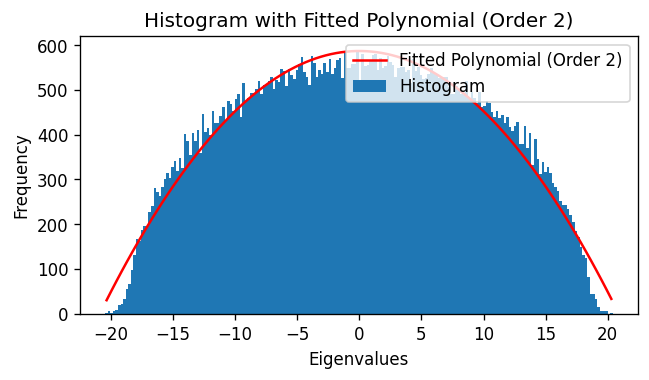

In [109]:
import numpy as np
import matplotlib.pyplot as plt

data = results

hist, bin_edges = np.histogram(data, bins=200)  # You can adjust the number of bins

bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

k = 2  #polynomial order
coefficients = np.polyfit(bin_centers, hist, k)
fitted_poly = np.poly1d(coefficients)

plt.figure(figsize=(6,3), dpi=120)
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], align='center', label='Histogram')
x_range = np.linspace(min(bin_centers), max(bin_centers), 100)  # Generate x values for the fitted polynomial
plt.plot(x_range, fitted_poly(x_range), 'r-', label=f'Fitted Polynomial (Order {k})')
plt.xlabel('Eigenvalues')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Histogram with Fitted Polynomial (Order {k})')
plt.show()


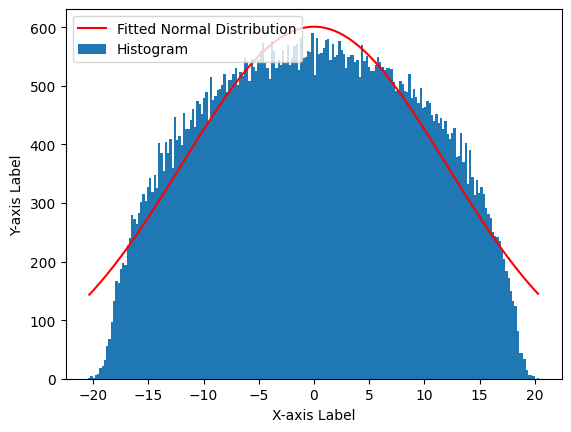

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

from scipy.optimize import curve_fit

# Define the normal distribution function
def normal_distribution(x, mu, sigma, scale):
    return scale * norm.pdf(x, loc=mu, scale=sigma)

# Fit the normal distribution to the histogram data
params, covariance = curve_fit(normal_distribution, bin_centers, hist)

# Extract the estimated parameters
mu, sigma, scale = params

plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], align='center', label='Histogram')
x = np.linspace(bin_centers.min(), bin_centers.max(), 100)
plt.plot(x, normal_distribution(x, mu, sigma, scale), 'r-', label='Fitted Normal Distribution')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()
plt.show()


In [115]:
# is it normal distribution?
from scipy.stats import shapiro
import random

# Generate some example data (replace this with your actual data)
data = [random.normalvariate(0, 1) for _ in range(100)]
data = results_par

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(data)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value > alpha:
    print("Data looks like it comes from a normal distribution (fail to reject H0)")
else:
    print("Data does not look like it comes from a normal distribution (reject H0)")


NameError: name 'results_par' is not defined